<a href="https://colab.research.google.com/github/3realm/ML_Start/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22hw_metric_models_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Метрические модели (kNN)


В этом задании мы поработаем с алгоритмом **k-ближайших соседей (kNN)** и разными метриками расстояния.

Напоминание:
- kNN ищет ближайших соседей объекта по выбранной метрике.
- Класс нового объекта определяется большинством среди соседей.

Метрика расстояния сильно влияет на работу модели:
- **Евклидово расстояние** — учитывает величины признаков.
- **Манхэттенское расстояние** — сумма модулей разниц.
- **Мера Жаккара** — для множеств / бинарных признаков.
- **Косинусное расстояние** — для текстов/векторов, где важен угол, а не длина.


## 1. Загрузка данных

Будем рассматривать эту модель на примере датасета с ирисами Фишера

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Загружаем датасет iris
iris = load_iris()
# Возьмём 2 признака: длина и ширина лепестка
X, y = iris.data[:, (2, 3)], iris.target
X_2d = X.copy()

print("Размерность X:", X.shape)
print("Классы:", iris.target_names)


Размерность X: (150, 2)
Классы: ['setosa' 'versicolor' 'virginica']


## 2. Первая модель kNN (евклидово расстояние)

In [ ]:

# Разделим данные на train/test в соотношении 0.8: 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y,
    train_size = 0.8,
    random_state = 42,
    stratify = y
)

# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # нашли μ и σ на train и сразу применили
X_test_scaled = scaler.transform(X_test)        # применили те же μ и σ к test

# Обучим kNN с евклидовой метрикой и количеством соседей = 5
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(X_train_scaled, y_train)

distances, indices = knn.kneighbors(X_test_scaled[:1], n_neighbors=5)
print("Индексы соседей:", indices)
print("Классы соседей:", y_train[indices[0]])
print("Расстояния:", distances)

# Сделаем предсказания на тестовом множестве
y_pred = knn.predict(X_test_scaled)

print("Accuracy (евклидово расстояние):", accuracy_score(y_test, y_pred))

Индексы соседей: [[116  60  72 117   0]]
Классы соседей: [0 0 0 0 0]
Расстояния: [[0.         0.         0.05678153 0.05678153 0.05678153]]
Accuracy (евклидово расстояние): 0.9666666666666667


## 3. Сравнение разных метрик

Обучим модель с использованием различных метрик расстояния: "euclidean", "manhattan", "cosine" и сравним получаемые значения accuracy_score

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



# split
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y, test_size=0.2, random_state=42, stratify=y
)

pipelines = {
    "euclidean": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5, metric="euclidean")
    ),
    "manhattan": make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=5, metric="manhattan")
    ),
    "cosine": make_pipeline(
        StandardScaler(),
        Normalizer(norm="l2"),  # для cosine часто полезно нормировать вектора до длины 1
        KNeighborsClassifier(n_neighbors=5, metric="cosine")
    ),
}

results = {}
for name, model in pipelines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"Accuracy ({name}): {acc:.4f}")


Accuracy (euclidean): 0.9667
Accuracy (manhattan): 0.9667
Accuracy (cosine): 0.8333


## 4. Визуализация границ для kNN

Построим границы классов для kNN для различных метрик

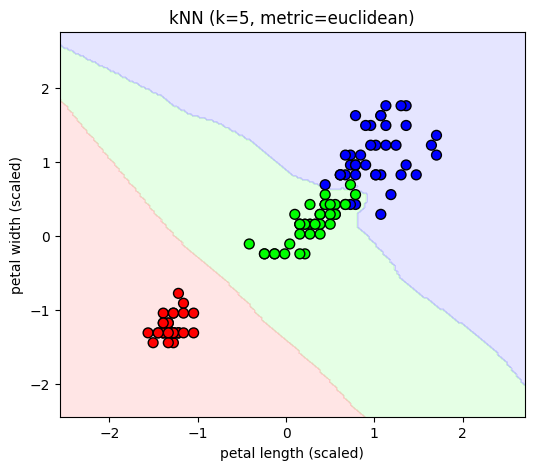

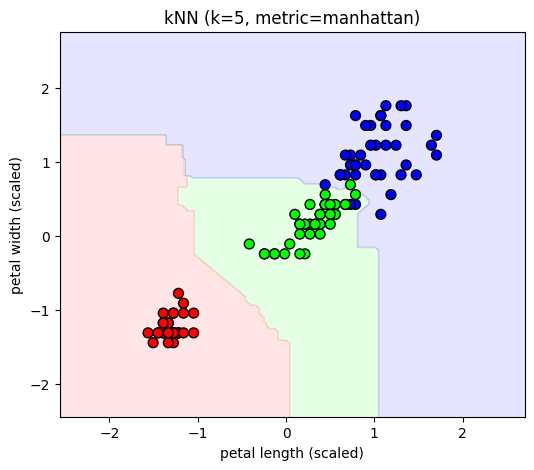

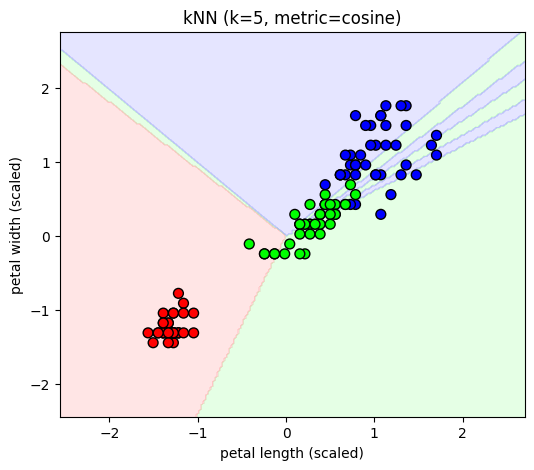

In [ ]:
from matplotlib.colors import ListedColormap

# Берём только 2 признака (лепестки)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2d, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train2_scaled = scaler.fit_transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

def plot_knn_boundaries(metric="euclidean", k=5):
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
    knn.fit(X_train2_scaled, y_train2)

    # Сетка для отрисовки
    x_min, x_max = X_train2_scaled[:, 0].min() - 1, X_train2_scaled[:, 0].max() + 1
    y_min, y_max = X_train2_scaled[:, 1].min() - 1, X_train2_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
    plt.scatter(X_train2_scaled[:, 0], X_train2_scaled[:, 1], c=y_train2, cmap=cmap_bold, edgecolor="k", s=50)
    plt.title(f"kNN (k={k}, metric={metric})")
    plt.xlabel("petal length (scaled)")
    plt.ylabel("petal width (scaled)")
    plt.show()

# Пример: визуализация для разных метрик
for m in ["euclidean", "manhattan", "cosine"]:
    plot_knn_boundaries(metric=m, k=5)



## 5. Подбор гиперпараметров

Попробуем подобрать с помощью алгоритма GridSearchCV оптимальные значения количества соседей и метрику.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# 1) Split
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Pipeline: scaler + (опционально) normalizer + knn
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("normalizer", "passthrough"),
    ("knn", KNeighborsClassifier())
])

# 3) Grid: два “режима”
# - euclidean/manhattan: без normalizer
# - cosine: с normalizer
param_grid = [
    {
        "normalizer": ["passthrough"], # шаг пайплайна normalizer ничего не делает.
        "knn__n_neighbors": list(range(1, 31, 2)),          # можно range(1, 31, 2) чтобы только нечётные
        "knn__metric": ["euclidean", "manhattan"],
        "knn__weights": ["uniform", "distance"],
    },
    {
        "normalizer": [Normalizer(norm="l2")],
        "knn__n_neighbors": list(range(1, 31, 2)),
        "knn__metric": ["cosine"],
        "knn__weights": ["uniform", "distance"],
    }
]

# 4) GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,            # StratifiedKFold по умолчанию для классификации
    n_jobs=-1,
    refit=True       # после поиска переобучит лучший пайплайн на всём train
)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучшая CV accuracy:", grid.best_score_)

# 5) Оценка на тесте
y_pred = grid.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))


Лучшие параметры: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'normalizer': 'passthrough'}
Лучшая CV accuracy: 0.9666666666666668
Test accuracy: 0.9666666666666667



## 6. Классификация текстов с kNN

- Сравним kNN с метрикой Жаккара и косинусным расстоянием на текстах.  
  Для этого можно взять небольшой список предложений и преобразовать их в мешок слов (`CountVectorizer`).

`CountVectorizer` работает следующим образом:
1. Проходит по всем текстам набора данных и составляет словарь, размер которого равен количеству уникальных токенов во всём корпусе текстов
2. Каждому токену присваивается индекс свой уникальный индекс i
3. Текст переводится в вектор размером длина словаря, в котором на i-ом месте записано число - частота встречаемости данного токена в данном тексте

Мы будем использовать корпус **20 newsgroups** из sklearn.  
Нужно векторизовать тексты с помощью `CountVectorizer` и обучить `KNeighborsClassifier`.  

`CountVectorizer` преобразует тексты в вектора следующим образом. Каждый текст превращается в вектор, размерность которого равна количеству слов во всём корпусе текстов. Каждому слову соответствует определённый индекс в этом векторе. Значение элемента равно количеству раз, которое слово встретилось в данном тексте. Если какого-то слова нет в тексте, то соответствующий элемент будет равен нулю.  

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# Загружаем небольшой корпус (только 3 категории)
categories = ['sci.space', 'rec.sport.hockey', 'comp.graphics']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)

X = newsgroups.data
y = newsgroups.target
print(y)

# Разделим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[1 0 2 ... 0 1 1]


In [ ]:
# Посмотрим на один пример
print(X_train[22])
print('~'*70)
print('label:', y_train[22])
print(y_train)
print(newsgroups.target_names)                 # порядок классов
print("label=2 ->", newsgroups.target_names[2])
mapping = {i: name for i, name in enumerate(newsgroups.target_names)}
print(mapping) # так удобнее

From: seale@possum.den.mmc.com (Eric H Seale)
Subject: Re: Comet in Temporary Orbit Around Jupiter?
Nntp-Posting-Host: pogo.den.mmc.com
Organization: Martin Marietta Astronautics, Denver
Lines: 8

baalke@kelvin.jpl.nasa.gov (Ron Baalke) writes:
>According the IAU Circular #5744, Comet Shoemaker-Levy 1993e, may be
>temporarily in orbit around Jupiter.  The comet had apparently made a
>close flyby of Jupiter sometime in 1992 resulting in the breakup of the
>comet.

Ooooh -- who would have thought that Galileo would get the chance to
check out a comet TOO?!?

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
label: 2
[0 0 2 ... 2 0 2]
['comp.graphics', 'rec.sport.hockey', 'sci.space']
label=2 -> sci.space
{0: 'comp.graphics', 1: 'rec.sport.hockey', 2: 'sci.space'}


Как видно, в текстах содержится много мусора: междометия, емейлы, названия сайтов. Проблема в том, что если мы применим `CountVectorizer` к необработанным текстам, размер словаря сильно увеличится, при этом многие из этих токенов не несут никакого смысла. Также мы не хотим, чтобы одно и то же слово, записанное в разных регистрах, воспринималось моделью как разные токены.

Поэтому перед применением алгоритма kNN следует выполнить предобработку текста. К счастью, алгоритм `CountVectorizer` может сам предобработать тексты. Для этого есть специальные параметры:
- **stop_words='english'**  
  Убирает стоп-слова (частые и малоинформативные слова вроде *"the"*, *"is"*, *"and"*).  
  Это помогает модели не тратить внимание на "шум".

- **lowercase=True**  
  Приводит все слова к нижнему регистру.  
  Например, "Dog" и "dog" будут считаться одним и тем же словом.

- **min_df=n**  
  Отбрасывает слова, которые встречаются **меньше чем в n документах**.  
  Такие редкие слова часто не помогают в классификации и могут мешать.

- **max_df=0.9**  
  Отбрасывает слова, которые встречаются **более чем в 90% документов**.  
  Очень частые слова не несут полезной информации (например, "said", "one").

- **token_pattern=r'[a-zA-Z]{2,}'**  
  Регулярное выражение для выделения слов (токенов).  
  Здесь мы берём только последовательности букв латинского алфавита длиной **не меньше 2 символов**.  
  → Однобуквенные "слова" вроде "a" или "I" будут отфильтрованы

Реализуем векторизацию текстов с использованием данных параметров

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english") # сделал просто параметр, но так
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Для простоты бинаризуем наши вектора: на i-ой позиции будет стоять 1, если слово присутствует в нашем тексте (неважно, какое количество раз), иначе - 0

In [ ]:
X_train_bin = (X_train_vec > 0).astype(int)
X_test_bin = (X_test_vec > 0).astype(int)

## 7. Реализация метрики Жаккара

В sklearn нет встроенной поддержки меры Жаккара в качестве метрики. Однако можно написать свою кастомную метрику вычисления расстояния и передать её как функцию в качестве значения параметра `metric`.

Реализуем вычисление меры Жаккара

In [ ]:
def jaccard_similarity(set1, set2):

    intersection = set1 & set2

    union = set1 | set2

    if len(union) == 0:
        return 0.0
    return len(intersection) / len(union)

# Проверка
print(jaccard_similarity({"cat", "dog"}, {"dog", "mouse"}))  # Ожидаем 1/3 ≈ 0.33


0.3333333333333333


In [ ]:
# Мера Жаккара
def jaccard_distance(x, y):
    return 1 - jaccard_similarity(x, y)

## 8. Сравнение метрик jaccard distance и cosine similarity

Обучим алгоритм kNN на текстах с использованием метрик cosine и jaccard_distance и сравним результаты при помощи набора метрик  `classification_report` из sklearn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

tfidf = TfidfVectorizer(stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

knn_cosine = KNeighborsClassifier(
    n_neighbors=5,
    metric="cosine",
    algorithm="brute",
    n_jobs=-1
)

knn_cosine.fit(X_train_tfidf, y_train)
y_pred_cosine = knn_cosine.predict(X_test_tfidf)

print("=== COSINE (TF-IDF) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_cosine))
print(classification_report(y_test, y_pred_cosine, target_names=newsgroups.target_names))


=== COSINE (TF-IDF) ===
Accuracy: 0.949438202247191
                  precision    recall  f1-score   support

   comp.graphics       0.94      0.94      0.94       128
rec.sport.hockey       0.95      0.97      0.96       114
       sci.space       0.96      0.94      0.95       114

        accuracy                           0.95       356
       macro avg       0.95      0.95      0.95       356
    weighted avg       0.95      0.95      0.95       356



In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

def jaccard_distance_sparse(A, B):
    """
    A: csr_matrix shape (n_a, n_features), бинарная (0/1)
    B: csr_matrix shape (n_b, n_features), бинарная (0/1)
    Возвращает dense np.array shape (n_a, n_b) с расстояниями Жаккара.
    """
    # intersection = |A ∩ B| для каждой пары строк -> dot product (так как 0/1)
    inter = (A @ B.T).toarray().astype(float)

    # суммы по строкам = |A| и |B|
    a_sum = A.sum(axis=1).A1.astype(float)  # (n_a,)
    b_sum = B.sum(axis=1).A1.astype(float)  # (n_b,)

    # union = |A| + |B| - intersection
    union = a_sum[:, None] + b_sum[None, :] - inter

    # similarity = inter / union (если union==0 -> 0)
    sim = np.divide(inter, union, out=np.zeros_like(inter), where=(union != 0))

    # distance = 1 - similarity
    return 1.0 - sim


# 1) бинарная векторизация
vec_bin = CountVectorizer(stop_words="english", binary=True)
X_train_bin = vec_bin.fit_transform(X_train)
X_test_bin = vec_bin.transform(X_test)

# 2) расстояния train-train (для fit) и test-train (для predict)
D_train = jaccard_distance_sparse(X_train_bin, X_train_bin)
np.fill_diagonal(D_train, 0.0)  # на всякий случай

D_test = jaccard_distance_sparse(X_test_bin, X_train_bin)

# 3) kNN на precomputed расстояниях
knn_jaccard = KNeighborsClassifier(n_neighbors=5, metric="precomputed")
knn_jaccard.fit(D_train, y_train)
y_pred_jaccard = knn_jaccard.predict(D_test)

print("=== JACCARD (binary BOW, precomputed) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_jaccard))
print(classification_report(y_test, y_pred_jaccard, target_names=newsgroups.target_names))


=== JACCARD (binary BOW, precomputed) ===
Accuracy: 0.9382022471910112
                  precision    recall  f1-score   support

   comp.graphics       0.88      0.96      0.92       128
rec.sport.hockey       0.96      0.94      0.95       114
       sci.space       0.98      0.91      0.95       114

        accuracy                           0.94       356
       macro avg       0.94      0.94      0.94       356
    weighted avg       0.94      0.94      0.94       356

